### Libraries

In [7]:
from DataPreprocessingFunction import preprocess_text
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split

In [8]:
data_all = pd.read_csv('Data/data_preproc_all.csv')
data_all = data_all[['Review_Text', 'Rating']]

def get_sentiment(rating):
    if rating > 3:
        return 1
    if rating < 3:
        return -1
    return 0

data_all['Sentiment'] = data_all['Rating'].apply(get_sentiment)
data_all = data_all[['Review_Text', 'Sentiment']]
#split data into train and test
data_train, data_test = train_test_split(data_all, test_size=0.2, stratify=data_all['Sentiment'])

data_train.to_csv('Data/data_train_preproc_all.csv', index=False)
data_test.to_csv('Data/data_test_preproc_all.csv', index=False)

In [9]:
data_train = pd.read_csv('Data/data_train_preproc_all.csv')
data_train_X = data_train['Review_Text']
data_train_y = data_train['Sentiment']
data_test = pd.read_csv('Data/data_test_preproc_all.csv')
data_test_X = data_test['Review_Text']
data_test_y = data_test['Sentiment']

In [10]:
class TextPreprocessor:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(preprocess_text)

    def fit_transform(self, X, y=None):
        return self.transform(X)


### Pipeline (BagOfWords + GradientBoosting)

In [11]:
pipeline_bag_of_words_gradient_boosting = Pipeline([
    # ('preprocess', TextPreprocessor()), i've done preprocessing previously, because it takes a lot of time each time
    ('vectorizer', CountVectorizer()),
    ('classifier', GradientBoostingClassifier(n_estimators=1000))
])

In [12]:
# random search
param_grid = {
    'vectorizer__max_features': randint(200, 5000),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__max_depth': randint(3, 10),
}

random_search = RandomizedSearchCV(
    pipeline_bag_of_words_gradient_boosting, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='accuracy', 
    cv=5,
    verbose=2, 
    n_jobs=-1, 
    random_state=42 
)

random_search.fit(data_train_X, data_train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 7.9min
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 7.9min
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 7.9min
[CV] END classifier__learning_rate=0.12236203565420874, classifier__max_depth=7, classifier__n_estimators=370, vectorizer__max_features=3972, vectorizer__ngram_range=(1, 1); total time=12.4min
[CV] END classifier__learning_rate=0.12236203565420874, classifier__max_depth=7, classifier__n_estimators=370, vectorizer__max_features=3972, vectorizer__ngram_range=(

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('classifier',
                                              GradientBoostingClassifier(n_estimators=1000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1686b4310>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16864bc10>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16864ba90>,
                                        'vectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1686b4220>,
                                        'vectorizer__ngram_range': [(1, 1),
                                                 

In [13]:
best_gradient_boosting = random_search.best_estimator_
best_gradient_boosting.fit(data_train_X, data_train_y)
predictions = best_gradient_boosting.predict(data_test_X)
cm = confusion_matrix(data_test_y, predictions)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
print(cm_df)


          Negative  Neutral  Positive
Negative       337      120       268
Neutral        145      215       662
Positive        58      138      6589


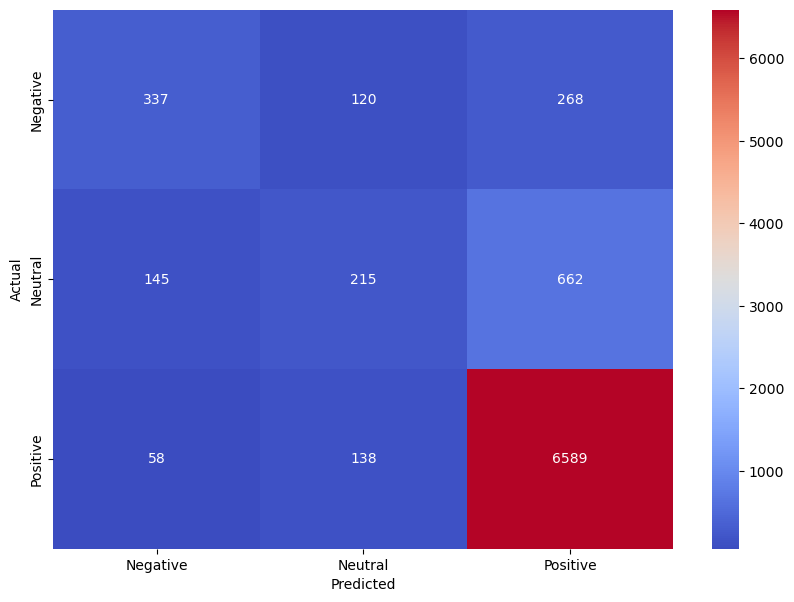

In [14]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='g')    
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# accuracy, precision, recall, f1
print(classification_report(data_test_y, predictions))

              precision    recall  f1-score   support

          -1       0.62      0.46      0.53       725
           0       0.45      0.21      0.29      1022
           1       0.88      0.97      0.92      6785

    accuracy                           0.84      8532
   macro avg       0.65      0.55      0.58      8532
weighted avg       0.80      0.84      0.81      8532



### Pipeline (TF-IDF+GradientBoosting)

In [16]:
pipeline_tf_idf_gradient_boosting = Pipeline([
    # ('preprocess', TextPreprocessor()), i've done preprocessing previously, because it takes a lot of time each time
    ('vectorizer', TfidfVectorizer()),
    ('classifier', GradientBoostingClassifier(n_estimators=1000))
])

In [17]:
random_search.fit(data_train_X, data_train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 5.2min
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 5.3min
[CV] END classifier__learning_rate=0.05680559213273095, classifier__max_depth=5, classifier__n_estimators=314, vectorizer__max_features=4626, vectorizer__ngram_range=(1, 3); total time= 5.3min
[CV] END classifier__learning_rate=0.12236203565420874, classifier__max_depth=7, classifier__n_estimators=370, vectorizer__max_features=3972, vectorizer__ngram_range=(1, 1); total time= 6.9min
[CV] END classifier__learning_rate=0.12236203565420874, classifier__max_depth=7, classifier__n_estimators=370, vectorizer__max_features=3972, vectorizer__ngram_range=(

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('classifier',
                                              GradientBoostingClassifier(n_estimators=1000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1686b4310>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16864bc10>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16864ba90>,
                                        'vectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1686b4220>,
                                        'vectorizer__ngram_range': [(1, 1),
                                                 

In [18]:
best_gradient_boosting_tf_idf = random_search.best_estimator_
best_gradient_boosting_tf_idf.fit(data_train_X, data_train_y)
predictions = best_gradient_boosting_tf_idf.predict(data_test_X)
cm = confusion_matrix(data_test_y, predictions)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
print(cm_df)

          Negative  Neutral  Positive
Negative       340      118       267
Neutral        149      212       661
Positive        56      140      6589


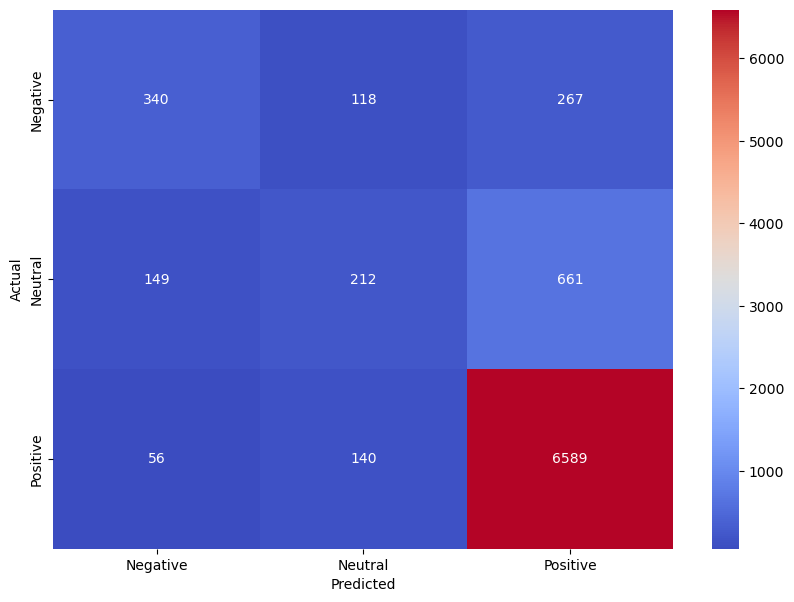

In [19]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
print(classification_report(data_test_y, predictions))

              precision    recall  f1-score   support

          -1       0.62      0.47      0.54       725
           0       0.45      0.21      0.28      1022
           1       0.88      0.97      0.92      6785

    accuracy                           0.84      8532
   macro avg       0.65      0.55      0.58      8532
weighted avg       0.80      0.84      0.81      8532

